In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.integrate import quad
from sklearn.metrics import roc_curve, auc, roc_auc_score
from matplotlib import pyplot as plt
from lifelines import KaplanMeierFitter

%matplotlib inline

import plotly.graph_objects as go
import plotly.figure_factory as ff

In [11]:
data = pd.read_excel('data\\part2.xlsx') 
data

,PD для 2-х,Статус
0,0.0008,Хороший
1,0.0009,Хороший
2,0.0010,Хороший
3,0.0010,Хороший
4,0.0010,Хороший
...,...,...
389,0.0286,Хороший
390,0.0301,Хороший
391,0.0303,Хороший
392,0.0353,Хороший


In [12]:
data.rename(columns={
    "PD для 2-х": "PD",
    "Статус": "status"
}, inplace=True)

data["status"] = data["status"].map({"Дефолт": 1, "Хороший": 0})

data

,PD,status
0,0.0008,0
1,0.0009,0
2,0.0010,0
3,0.0010,0
4,0.0010,0
...,...,...
389,0.0286,0
390,0.0301,0
391,0.0303,0
392,0.0353,0


In [13]:
def gini(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    return 2 * auc(fpr, tpr) - 1

In [14]:
gini_value = gini(data["status"], data["PD"])
print(f"GINI: {gini_value:.4f}")

GINI: 0.5683


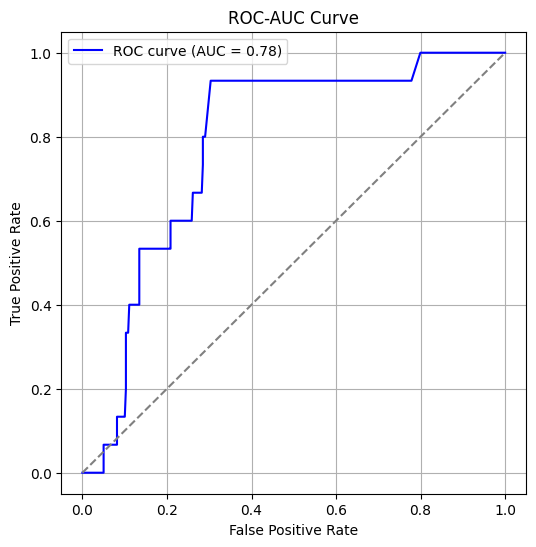

In [15]:
fpr, tpr, _ = roc_curve(data["status"], data["PD"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Диагональ случайного классификатора
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.grid()
plt.show()

In [16]:
ks_value = np.max(tpr - fpr)
print(f"KS: {ks_value:.4f}")

KS: 0.6299


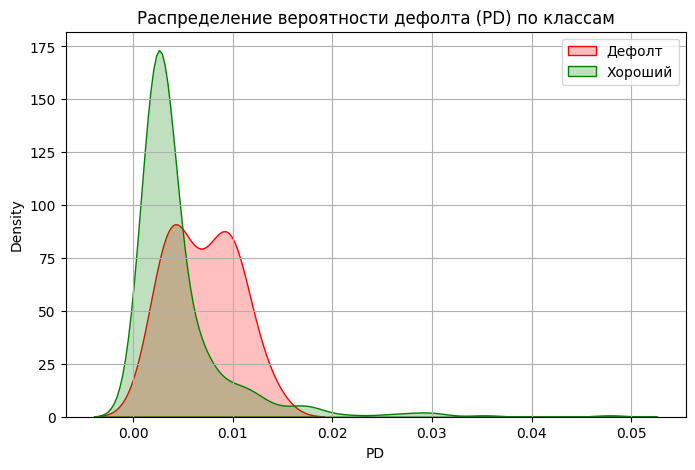

In [18]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data.loc[data["status"] == 1, "PD"], label="Дефолт", fill=True, color="red")
sns.kdeplot(data.loc[data["status"] == 0, "PD"], label="Хороший", fill=True, color="green")
plt.xlabel("PD")
plt.ylabel("Density")
plt.title("Распределение вероятности дефолта (PD) по классам")
plt.legend()
plt.grid()
plt.show()

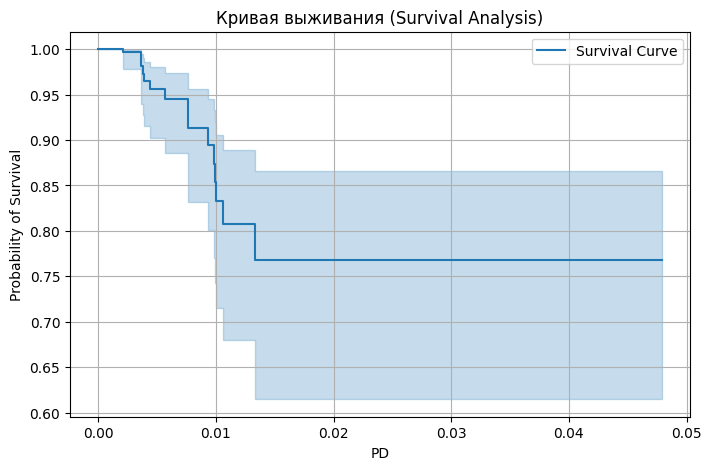

In [21]:
kmf = KaplanMeierFitter()

T = data["PD"]  # Переменная времени (PD в данном случае)
E = data["status"]  # Переменная события (1 - дефолт, 0 - нет)

plt.figure(figsize=(8, 5))
kmf.fit(T, event_observed=E, label="Survival Curve")
kmf.plot_survival_function()
plt.xlabel("PD")
plt.ylabel("Probability of Survival")
plt.title("Кривая выживания (Survival Analysis)")
plt.grid()
plt.show()

In [ ]:
fpr, tpr, _ = roc_curve(data["status"], data["PD"])
roc_auc = auc(fpr, tpr)

# 1. ROC-AUC
roc_fig = go.Figure()
roc_fig.add_trace(go.Scatter(x=fpr, y=tpr, mode="lines", name=f"ROC curve (AUC = {roc_auc:.2f})", line=dict(color="blue")))
roc_fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode="lines", name="Random classifier", line=dict(color="gray", dash="dash")))
roc_fig.update_layout(
    title="ROC-AUC Curve",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    xaxis=dict(showgrid=True),  # Добавляем сетку для оси X
    yaxis=dict(showgrid=True)   # Добавляем сетку для оси Y
)

# 2. График распределения PD для двух классов
hist_data = [data.loc[data["status"] == 1, "PD"], data.loc[data["status"] == 0, "PD"]]
group_labels = ["Дефолт", "Хороший"]

dist_fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
dist_fig.update_layout(
    title="Распределение вероятности дефолта (PD) по классам",
    xaxis_title="PD",
    yaxis_title="Density",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

# 3. Survival Analysis
kmf = KaplanMeierFitter()
T = data["PD"]
E = data["status"]

kmf.fit(T, event_observed=E, label="Survival Curve")
survival_fig = go.Figure()
survival_fig.add_trace(go.Scatter(x=kmf.survival_function_.index, y=kmf.survival_function_["Survival Curve"], mode="lines", name="Survival Probability", line=dict(color="green")))
survival_fig.update_layout(
    title="Кривая выживания (Survival Analysis)",
    xaxis_title="PD",
    yaxis_title="Probability of Survival",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

# Отобразить все графики
roc_fig.show()
dist_fig.show()
survival_fig.show()
